## Семинар 7: "Методы оптимизации"

ФИО: Шевченко Олег

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
#from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch import functional as F
from torch.autograd import Variable

%matplotlib notebook
import seaborn
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [15]:
class Optimizer():
    def __init__(self, variables):
        self.variables = variables
        
    def step(self, loss):
        pass
    
class GD(Optimizer):
    def __init__(self, variables, learning_rate):
        super().__init__(variables)
        self.lr = learning_rate
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v in self.variables:
                v -= self.lr * v.grad
                
                v.grad.data.zero_()
                
class Momentum(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class NAG(Optimizer):
    def __init__(self, variables, learning_rate, gamma=0.9):
        super().__init__(variables)
        self.lr = learning_rate
        self.g = gamma
        
        self.moments = []        
        for v in self.variables:
            self.moments.append(torch.zeros_like(v.data))
        
    def step(self, J):
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                moment *= self.g                
                v -= moment
        
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, moment in zip(self.variables, self.moments):
                v += moment
                
                moment += self.lr * v.grad
                
                v -= moment
                
                v.grad.data.zero_()
                
class Adagrad(Optimizer):
    def __init__(self, variables, learning_rate, eps=10**-8):
        super().__init__(variables)
        self.lr = learning_rate
        self.eps = eps
        
        self.g_sq = []
        for v in self.variables:
            self.g_sq.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, g_sq in zip(self.variables, self.g_sq):      
                g_sq += v.grad**2
                v -= self.lr / (g_sq + self.eps).sqrt() * v.grad
                
                v.grad.data.zero_()

class Adadelta(Optimizer):
    def __init__(self, variables, learning_rate, gamma = 0.1, eps = 10 ** -8):
        super().__init__(variables)
        self.lr = learning_rate
        self.gamma = gamma
        self.eps = eps
        self.E_gt = []
        self.E_qt = []
        self.q_delta = []
        for v in self.variables:
            self.E_gt.append(torch.zeros_like(v.data))
            self.E_qt.append(torch.zeros_like(v.data))
            self.q_delta.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        
        with torch.no_grad():
            for v, E_gt, E_qt, q_delta in zip(self.variables, self.E_gt, self.E_qt, self.q_delta):
                
#                 E_qt = self.gamma * E_qt + (1 - self.gamma) * q_delta ** 2
                E_qt *= self.gamma
                E_qt += (1 - self.gamma) * q_delta ** 2
#                 E_gt = self.gamma * E_gt + (1 - self.gamma) * v.grad ** 2
                E_gt *= self.gamma
                E_gt += (1 - self.gamma) * v.grad ** 2
                q_delta.copy_(np.sqrt(E_qt + self.eps) * v.grad / np.sqrt(E_gt + self.eps))
                
                v -= q_delta
                v.grad.data.zero_()
                
class Adam(Optimizer):
    def __init__(self, variables, learning_rate, b1 = 0.9, b2 = 0.999, eps = 10 ** -8):
        super().__init__(variables)
        self.lr = learning_rate
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.mt = []
        self.vt = []
        self.t = 0
        for v in self.variables:
            self.mt.append(torch.zeros_like(v.data))
            self.vt.append(torch.zeros_like(v.data))
        
    def step(self, J):
        loss = J()
        loss.backward()
        self.t += 1
        with torch.no_grad():
            for v, mt, vt in zip(self.variables, self.mt, self.vt):
                mt *= self.b1
                mt += (1 - self.b1) * v.grad
                mt /= (1 - self.b1 ** self.t)
                # mt = (self.b1 * mt + (1 - self.b1) * v.grad) / (1 - self.b1 ** self.t)
                # vt = (self.b2 * vt + (1 - self.b2) * v.grad ** 2) / (1 - self.b2 ** self.t)
                vt *= self.b2
                vt += (1 - self.b2) * v.grad ** 2
                vt /= (1 - self.b2 ** self.t)
                v -= self.lr / (vt + self.eps).sqrt() * mt
                
                v.grad.data.zero_()

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [4]:
def apply_opt(optim, J, n_iters=1000):    
    points = []

    for i in range(n_iters):
        points.append((X.item(), Y.item(), J().item()))
        optim.step(J)

    points = np.array(points)
    return points

<IPython.core.display.Javascript object>


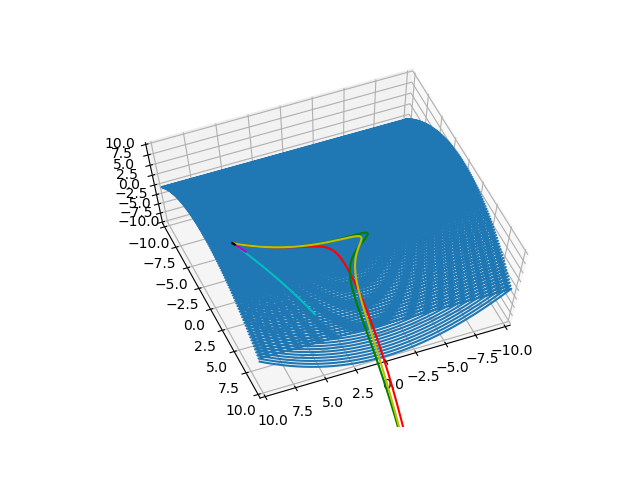

In [14]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
    return X**2/10 - Y**2/10
#     return X**2/10 * X.sin() - Y**2/10 * Y.cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)

ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
# ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
# ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)    
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=Colors[i])
    i += 1
#plt.axis('equal')
plt.show()

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

<IPython.core.display.Javascript object>


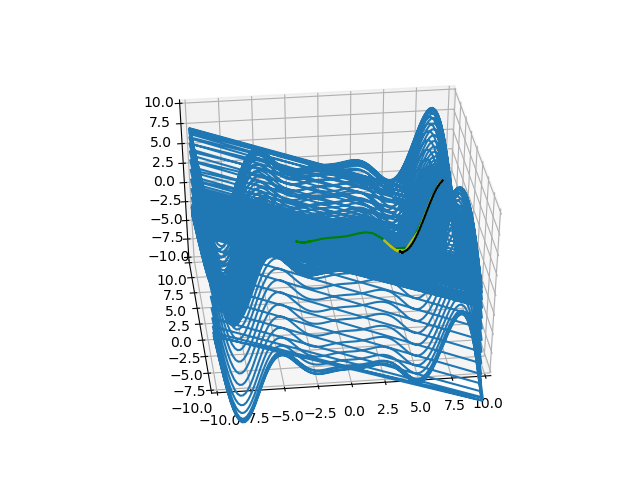

In [20]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
#     return X**2/10 - Y**2/10
    return X**2/10 * X.sin() + Y**2/10 * Y.cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)

ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
# ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
# ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)    
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=Colors[i])
    i += 1
#plt.axis('equal')
plt.show()

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

<IPython.core.display.Javascript object>


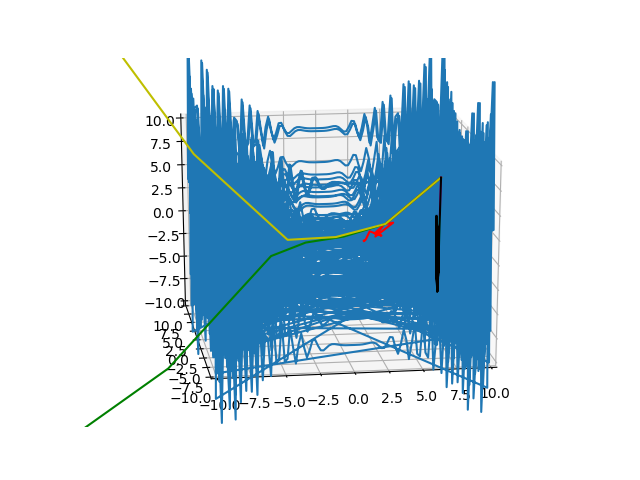

In [23]:
optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
          lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]

def J(X, Y):
#     return X**2/10 - Y**2/10
    return X**2/10 * (X**2).sin() + Y**2/10 * (Y**2).cos()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

R = 10
X = np.linspace(-R, R, 100)
Y = np.linspace(-R, R, 100)

ax.set_xlim3d(-R, +R)
ax.set_ylim3d(-R, +R)
ax.set_zlim3d(-R, +R)

xx, yy = np.meshgrid(X, Y)

xx = torch.from_numpy(xx)
yy = torch.from_numpy(yy)

Z = J(xx, yy)

ax.plot(xx.numpy().flatten(), yy.numpy().flatten(), Z.numpy().flatten())
# ax.plot_surface(xx.numpy(), yy.numpy(), Z.numpy())
# ax.plot_wireframe(xx.numpy(), yy.numpy(), Z.numpy())
Colors = ['r', 'g', 'y', 'c', 'm', 'k']
i = 0
for optim in optims:
    X = Variable(torch.tensor(float(8)), requires_grad=True)
    Y = Variable(torch.tensor(float(0.1)), requires_grad=True)    
    
    points = apply_opt(optim([X, Y]), lambda X=X, Y=Y: J(X, Y), 500)

    ax.plot(points[:, 0], points[:, 1], points[:, 2], c=Colors[i])
    i += 1
#plt.axis('equal')
plt.show()

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision import transforms
from tqdm import tqdm

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = datasets.MNIST(download=True, train=True, root='./data', transform=transform)
test_dataset = datasets.MNIST(download=True, root='./data', train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
epoch=5

In [7]:
linear = nn.Sequential(nn.Linear(784, 200), 
                       nn.ELU(),
                       nn.Linear(200, 100),
                       nn.ELU(),
                       nn.Linear(100, 10),
                       nn.LogSoftmax(dim=1))

loss_func = nn.NLLLoss()
# optims = [lambda v: GD(v, 0.1), lambda v: Momentum(v, 0.1), lambda v: NAG(v, 0.1), 
#           lambda v: Adagrad(v, 0.1), lambda v: Adadelta(v, 0.1), lambda v: Adam(v, 0.1)]
adam = Adam(linear.parameters(), 1e-2)
adagrad = Adagrad(linear.parameters(), 1e-2)
adadelta = Adadelta(linear.parameters(), 1e-2)
sgd = GD(linear.parameters(), 1e-2)

In [12]:
def compare_optim(optim, epoch, model, loss_function):
    epoch_losses_train = []
    epoch_losses_test = []
    for i in tqdm(range(epoch)):
        losses = []
        for x, y in train_loader:
#             x = torch.FloatTensor(x).view(x.size(0), -1)
            model.zero_grad()
            y_pred = model(x)

            loss = loss_function(y_pred, y)
#             optim.zero_grad()
#             loss.backward()
            optim.step(lambda Y_pred=y_pred, Y=y: loss_function(Y_pred, Y))
#             loss.backward()
            losses.append(loss.item())
        epoch_losses_train.append(np.mean(losses))
        losses = []
        for x, y in test_loader:
#             x = torch.FloatTensor(x).view(x.shape[0], -1)
#             model.zero_grad()
            y_pred = model(x)

            loss = loss_function(y_pred, y)
            losses.append(loss.item())
        epoch_losses_test.append(np.mean(losses))
    return epoch_losses_train, epoch_losses_test

In [16]:
class FullClf(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), 
                                           nn.ELU(),
                                           nn.Linear(200, 100),
                                           nn.ELU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [20]:
adam_losses_train, adam_losses_test = compare_optim(adam, epoch, linear, loss_func)
print('adam')
adagrad_losses_train, adagrad_losses_test = compare_optim(adagrad, epoch, linear, loss_func)
print('adagraad')
adadelta_losses_train, adadelta_losses_test = compare_optim(adadelta, epoch, linear, loss_func)
print('adadelta')
sgd_losses_train, sgd_losses_test = compare_optim(sgd, epoch, linear, loss_func)
print('sgd')

  0%|          | 0/5 [00:00<?, ?it/s]

adam


  0%|          | 0/5 [00:00<?, ?it/s]

adagraad


  0%|          | 0/5 [00:00<?, ?it/s]

adadelta


100%|██████████| 5/5 [01:28<00:00, 17.74s/it]

sgd


<IPython.core.display.Javascript object>


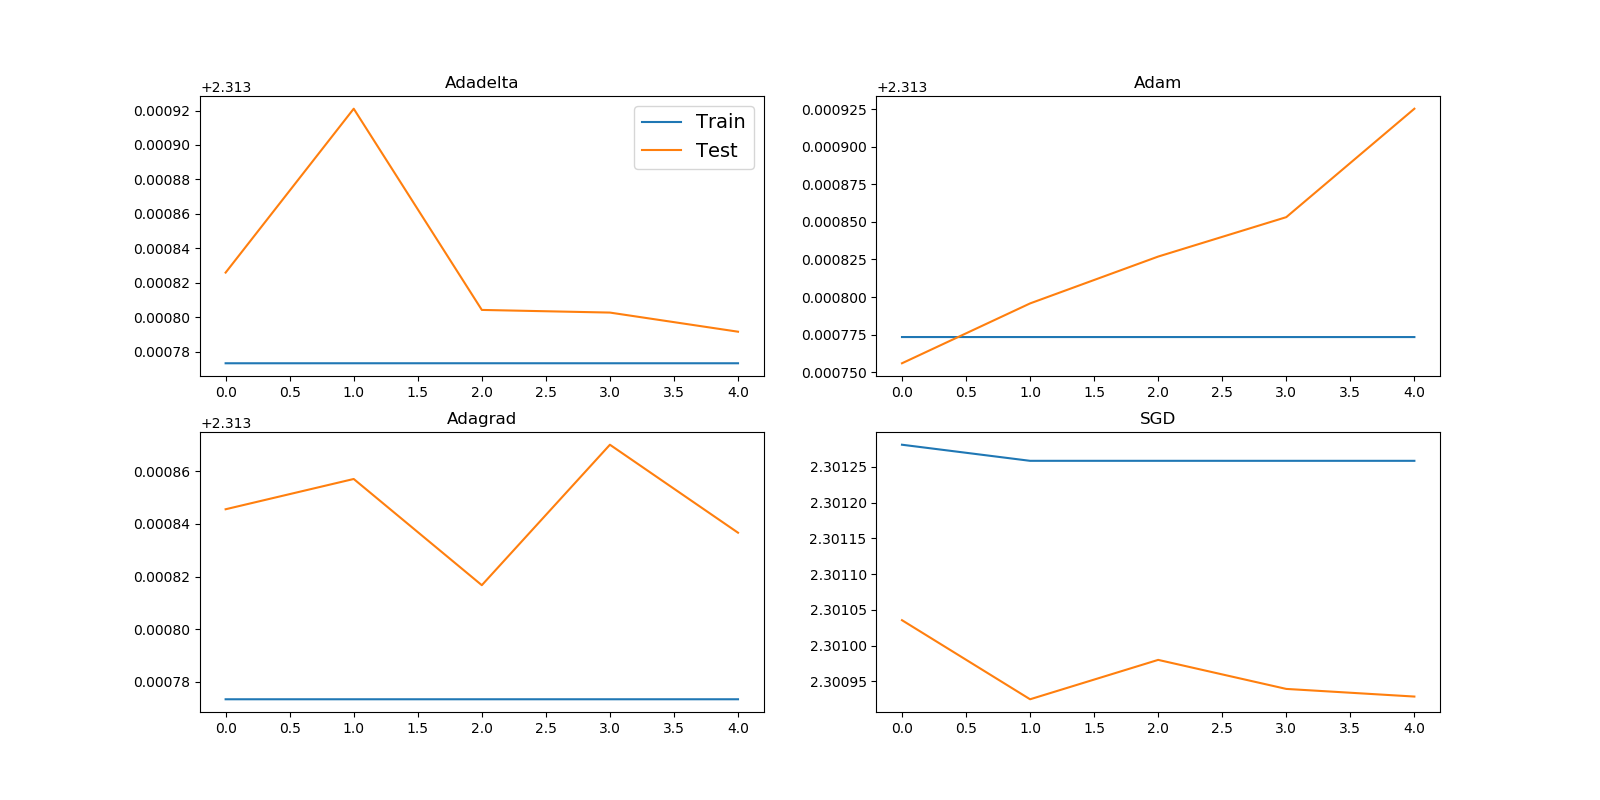

Text(0.5, 1.0, 'SGD')

In [21]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_losses_train, label='Train')
plt.plot(adam_losses_test, label='Test')
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_losses_train, label='Train')
plt.plot(adadelta_losses_test, label='Test')
plt.legend(loc=1, fontsize=14)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_losses_train, label='Train')
plt.plot(adagrad_losses_test, label='Test')
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_losses_train, label='Train')
plt.plot(sgd_losses_test, label='Test')
plt.title("SGD")

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [6]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 8, (3, 3), padding=1), nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*32, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
conv = ConvClassifier(image_size=28)


loss_func = nn.NLLLoss()
adam = Adam(conv.parameters(), lr=1e-2)
adagrad = Adagrad(conv.parameters(), lr=1e-2)
adadelta = Adadelta(conv.parameters(), lr=1e-2)
sgd = GD(conv.parameters(), lr=1e-2)

In [13]:
adam_losses_train, adam_losses_test = compare_optim(adam, epoch, conv, loss_func)
print('adam')
adagrad_losses_train, adagrad_losses_test = compare_optim(adagrad, epoch, conv, loss_func)
print('adagraad')
adadelta_losses_train, adadelta_losses_test = compare_optim(adadelta, epoch, conv, loss_func)
print('adadelta')
sgd_losses_train, sgd_losses_test = compare_optim(sgd, epoch, conv, loss_func)
print('sgd')

  0%|          | 0/5 [00:00<?, ?it/s]

adam


  0%|          | 0/5 [00:00<?, ?it/s]

adagraad


  0%|          | 0/5 [00:00<?, ?it/s]

adadelta


100%|██████████| 5/5 [02:54<00:00, 34.85s/it]

sgd


<IPython.core.display.Javascript object>


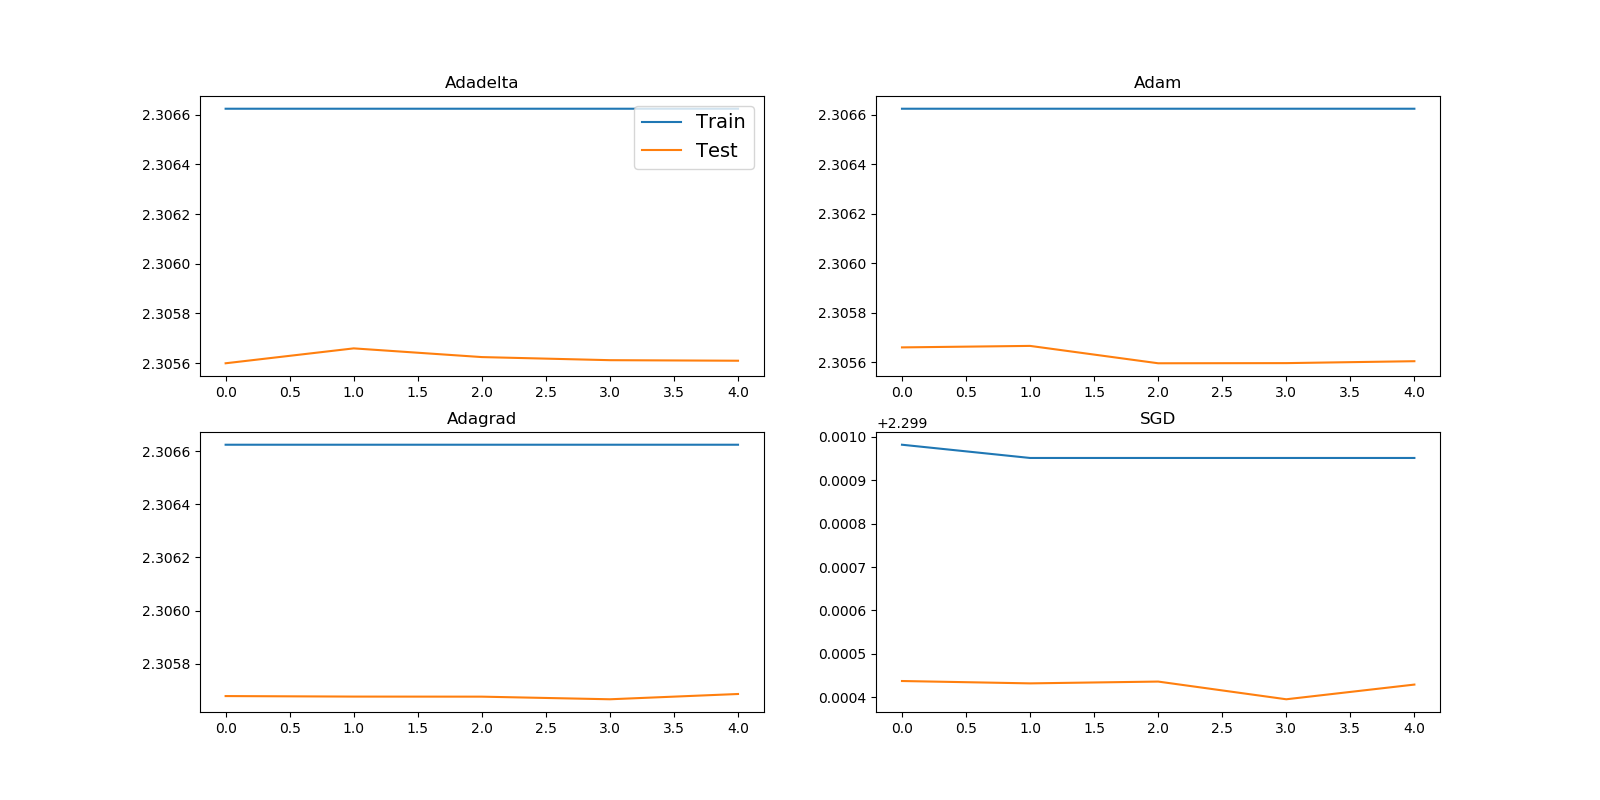

Text(0.5, 1.0, 'SGD')

In [14]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(222)
plt.plot(adam_losses_train, label='Train')
plt.plot(adam_losses_test, label='Test')
plt.title("Adam")

fig.add_subplot(221)
plt.plot(adadelta_losses_train, label='Train')
plt.plot(adadelta_losses_test, label='Test')
plt.legend(loc=1, fontsize=14)
plt.title("Adadelta")

fig.add_subplot(223)
plt.plot(adagrad_losses_train, label='Train')
plt.plot(adagrad_losses_test, label='Test')
plt.title("Adagrad")

fig.add_subplot(224)
plt.plot(sgd_losses_train, label='Train')
plt.plot(sgd_losses_test, label='Test')
plt.title("SGD")

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: